Load the JSONs

In [2]:
import os
import json

json_files_dir = os.path.join(os.getcwd(), 'json')
json_files = [f for f in os.listdir(json_files_dir) if f.endswith('.json')]

In [3]:
%%capture
!pip install matplotlib
!pip install requests

In [76]:
import requests
from collections import defaultdict

# Function to get country from IP address using the API
def get_country(ip_address):
    try:
        #print(f'Getting country for IP address: {ip_address}')
        response = requests.get(f'https://api.iplocation.net/?ip={ip_address}')
        if response.status_code == 200:
            country = response.json().get('country_code2', {})
            return country
        else:
            return "Unknown"
    except requests.RequestException:
        return "Unknown"

In [77]:
class Probe:
    def __init__(self, name, values):
        self.name = name
        if isinstance(values, dict):
            # Modify the dictionary to change "from" to "from_ip"
            modified_values = {("from_ip" if k == "from" else k): v for k, v in values.items()}
            self.__dict__.update(modified_values)
            self.country = get_country(self.from_ip)
        else:
            raise TypeError("Expected a dictionary")

class Destination:
    def __init__(self, name):
        self.name = name
        self.probes = []

    def add_probe(self, probe):
        if isinstance(probe, Probe):
            self.probes.append(probe)
        else:
            raise TypeError("Expected a Probe instance")

In [78]:
destinations = {}

for json_file in json_files:
    with open(os.path.join(json_files_dir, json_file), 'r') as f:
        data = json.load(f)
        name = json_file.split('.')[0]
        destination = Destination(name)
        destinations[name] = destination
        for measure in data:
            probe = Probe(name, measure)
            destination.add_probe(probe)
        
print(destinations['bet365'].probes[12].prb_id)

60623


In [96]:
destination_country_probes = defaultdict(lambda: defaultdict(list))

for destination in destinations.values():
    print(f"Destination: {destination.name}")
    for probe in destination.probes:
        destination_country_probes[destination.name][probe.country].append(probe)

Destination: bet365
Destination: betnacional
Destination: betway


In [102]:
print(len(destination_country_probes['bet365']['AR']))

12


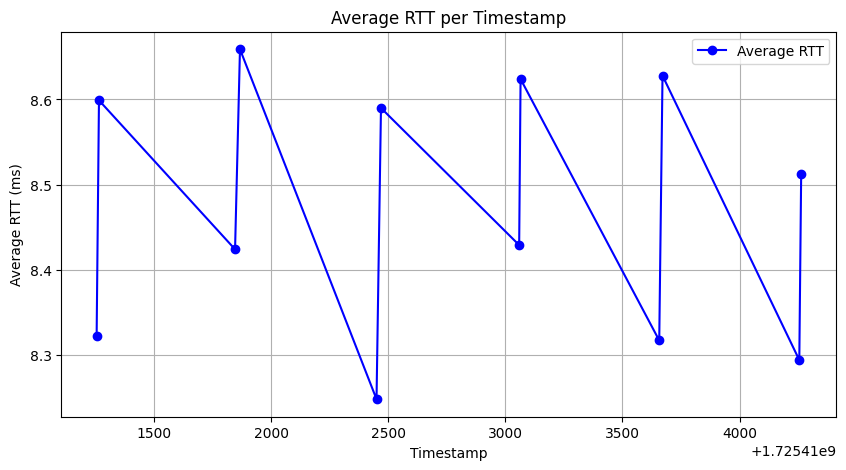

In [124]:
timestamp_rtt_br = defaultdict(list)

for probe in destination_country_probes['bet365']['AR']:
    if probe.result and probe.result[-1].get("result"):
        rtt = probe.result[-1]["result"][-1].get("rtt", 0)
        timestamp = probe.timestamp
        #print(f'Timestamp: {timestamp}, latency: {rtt}')
        timestamp_rtt_br[timestamp].append(rtt)
    else:
        #print("Probe failed, id: ",probe.prb_id)
        rtt = 0
        timestamp = probe.timestamp
        timestamp_rtt_br[timestamp].append(rtt)
        
# Calculate the average RTT for each timestamp
average_rtt_br = {timestamp: sum(rtts) / len(rtts) for timestamp, rtts in timestamp_rtt_br.items()}

sorted_timestamps = sorted(average_rtt_br.keys())
sorted_rtts = [average_rtt_br[timestamp] for timestamp in sorted_timestamps]

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(sorted_timestamps, sorted_rtts, marker='o', linestyle='-', color='b', label='Average RTT')
plt.xlabel('Timestamp')
plt.ylabel('Average RTT (ms)')
plt.title('Average RTT per Timestamp')
plt.legend()
plt.grid(True)
plt.show()

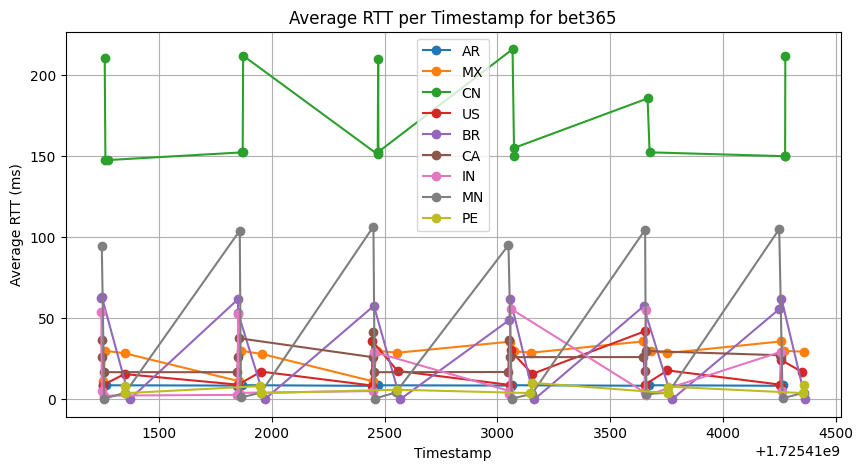

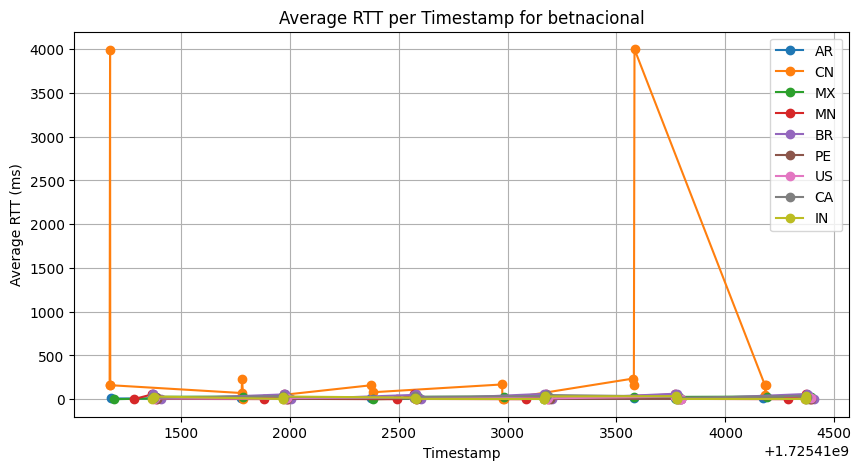

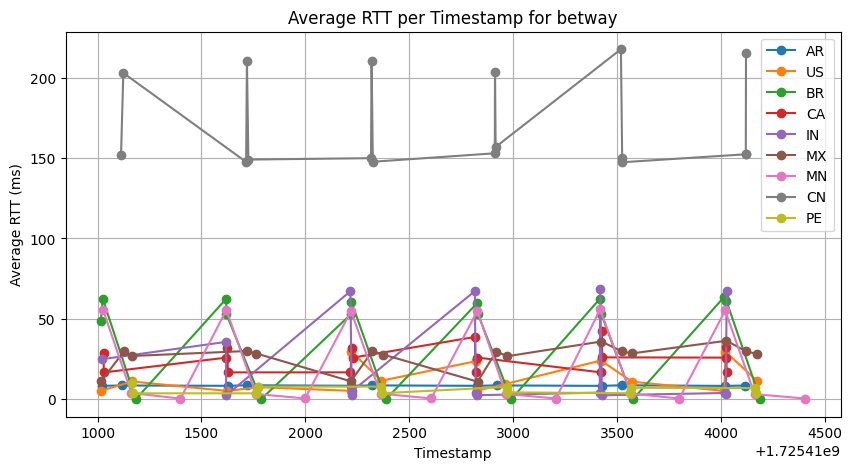

In [125]:
# Initialize a dictionary to store the average RTT per timestamp for each country and destination
average_rtt = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Iterate over the destination_country_probes dictionary
for destination, countries in destination_country_probes.items():
    for country, probes in countries.items():
        for probe in probes:
            if probe.result and probe.result[-1].get("result"):
                rtt = probe.result[-1]["result"][-1].get("rtt", 0)
                timestamp = probe.timestamp
                average_rtt[destination][country][timestamp].append(rtt)
            else:
                rtt = 0
                timestamp = probe.timestamp
                average_rtt[destination][country][timestamp].append(rtt)

# Calculate the average RTT for each timestamp for each country
for destination, countries in average_rtt.items():
    for country, timestamps in countries.items():
        for timestamp, rtts in timestamps.items():
            average_rtt[destination][country][timestamp] = sum(rtts) / len(rtts)

# Plot the data
for destination, countries in average_rtt.items():
    plt.figure(figsize=(10, 5))
    for country, timestamps in countries.items():
        sorted_timestamps = sorted(timestamps.keys())
        sorted_rtts = [timestamps[timestamp] for timestamp in sorted_timestamps]
        plt.plot(sorted_timestamps, sorted_rtts, marker='o', linestyle='-', label=country)
    plt.xlabel('Timestamp')
    plt.ylabel('Average RTT (ms)')
    plt.title(f'Average RTT per Timestamp for {destination}')
    plt.legend()
    plt.grid(True)
    plt.show()